<a href="https://colab.research.google.com/github/VeerendarGoud/ML-Projects/blob/master/OLA_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [152]:
!pip install xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

In [103]:
# get version
from platform import python_version
print(python_version())


3.8.10


In [104]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)


/usr/bin/python3
3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


# Problem statement 

**Problem Statement**

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

    Demographics (city, age, gender etc.)
    Tenure information (joining date, Last Date)
    Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


# EDA

In [105]:
df = pd.read_csv("/content/ola_driver_scaler.csv", index_col='Unnamed: 0')

# Data Preprocessing

In [106]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.0+ MB


observation: data types

Column Profiling:

    MMMM-YY : Reporting Date (Monthly)
    Driver_ID : Unique id for drivers
    Age : Age of the driver
    Gender : Gender of the driver – Male : 0, Female: 1
    City : City Code of the driver
    Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
    Income : Monthly average Income of the driver
    Date Of Joining : Joining date for the driver
    LastWorkingDate : Last date of working for the driver
    Joining Designation : Designation of the driver at the time of joining
    Grade : Grade of the driver at the time of reporting
    Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
    Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)


In [108]:
date_cols = ['Dateofjoining','LastWorkingDate', 'MMM-YY' ]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [109]:
df

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2020-08-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,2,2,740280,3
19100,2020-09-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,2,2,448370,3
19101,2020-10-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,2,2,0,2
19102,2020-11-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,2,2,200420,2


In [110]:
# drop duplicate driver ids
df['Driver_ID'].unique().size


2381

In [111]:
# helper functions
def df_tranform(df_group):

    df_group['total_income'] = df_group['Income'].sum()

    df_group['total_business_value'] = df_group['Total Business Value'].sum()

    df_group['target'] = 1 if df_group['LastWorkingDate'].any() else 0

    df_group['number_of_months'] = df_group['MMM-YY'].count()

    # Grade, Quarterly Rating, Education_Level

    df_group['change_grade'] = df_group['Grade'].max() - df_group['Grade'].min()

    df_group['Grade'] = df_group['Grade'].max()

    df_group['Quarterly Rating'] = df_group['Quarterly Rating'].max()

    df_group['Education_Level'] = df_group['Education_Level'].max() 
    
    df_group['Age'] = df_group['Age'].max()

    return df_group


def col_names_adj(name):
    import re
    name = name.lower()
    name = re.sub(r"[^\w]", '_', name)
    name = re.sub(r"[\s]", '_', name)
    return name



In [112]:
df = df.groupby('Driver_ID').apply(df_tranform)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19104 entries, 0 to 19103
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19104 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
 13  total_income    

In [114]:
df.drop(['MMM-YY', 'Income', 'Dateofjoining', 'LastWorkingDate', 'Total Business Value'], inplace=True, axis=1)

In [115]:
df

,Driver_ID,Age,Gender,City,Education_Level,Joining Designation,Grade,Quarterly Rating,total_income,total_business_value,target,number_of_months,change_grade
0,1,28.0,0.0,C23,2,1,1,2,172161,1715580,1,3,0
1,1,28.0,0.0,C23,2,1,1,2,172161,1715580,1,3,0
2,1,28.0,0.0,C23,2,1,1,2,172161,1715580,1,3,0
3,2,31.0,0.0,C7,2,2,2,1,134032,0,0,2,0
4,2,31.0,0.0,C7,2,2,2,1,134032,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2788,30.0,0.0,C27,2,2,2,3,491778,2298240,0,7,0
19100,2788,30.0,0.0,C27,2,2,2,3,491778,2298240,0,7,0
19101,2788,30.0,0.0,C27,2,2,2,3,491778,2298240,0,7,0
19102,2788,30.0,0.0,C27,2,2,2,3,491778,2298240,0,7,0


In [116]:
df.columns = [col_names_adj(col) for col in df.columns]

In [117]:
df_uniq = df.drop_duplicates()

In [118]:
df_uniq.reset_index(inplace=True, drop=True)

In [158]:
df_uniq

,driver_id,age,gender,city,education_level,joining_designation,grade,quarterly_rating,total_income,total_business_value,target,number_of_months,change_grade
0,1,28.0,0.0,C23,2,1,1,2,172161,1715580,1,3,0
1,2,31.0,0.0,C7,2,2,2,1,134032,0,0,2,0
2,4,43.0,0.0,C13,2,2,2,1,328015,350000,1,5,0
3,5,29.0,0.0,C9,0,1,1,1,139104,120360,1,3,0
4,6,31.0,1.0,C11,1,3,3,2,393640,1265000,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,2784,34.0,0.0,C24,0,2,3,4,1987560,21748820,0,24,0
2428,2785,34.0,1.0,C9,0,1,1,1,36315,0,1,3,0
2429,2786,45.0,0.0,C19,0,2,2,2,318330,2815090,1,9,0
2430,2787,28.0,1.0,C20,2,1,1,2,416988,977830,1,6,0


In [157]:
df_uniq['target'].value_counts()/df_uniq.shape[0]

1    0.680099
0    0.319901
Name: target, dtype: float64

In [176]:
X = df_uniq.drop(['target', 'driver_id', 'city'], axis=1)
y = df_uniq['target']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X, y, test_size=0.10, 
                                                random_state=42)

In [162]:
df_uniq['target']

0       1
1       0
2       1
3       1
4       0
       ..
2427    0
2428    1
2429    1
2430    1
2431    0
Name: target, Length: 2432, dtype: int64

## Univariate Analysis 

#### Target

In [136]:
df_uniq['target'].value_counts()

1    1654
0     778
Name: target, dtype: int64

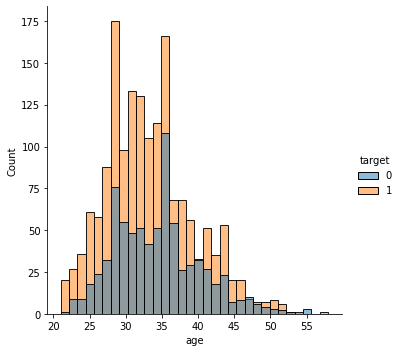

In [143]:
sns.displot(data=df_uniq, x = 'age', hue='target')
plt.show()

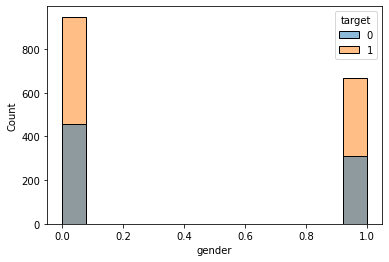

In [148]:
sns.histplot(data=df_uniq, x = 'gender', hue='target', multiple='layer')
plt.show()

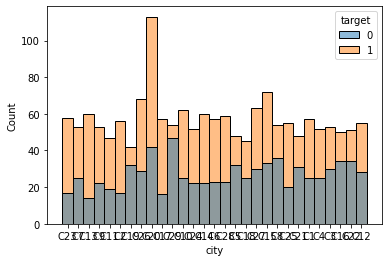

In [151]:
sns.histplot(data=df_uniq, x = 'city', hue='target', multiple='layer')
plt.show()

## Bivariate Analysis

# Model development

In [186]:
# X_train, X_test, y_train, y_test
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [174]:
xgb_cl = xgb.XGBClassifier()

In [184]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5]
}

In [178]:

xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

In [180]:
accuracy_score(y_test, preds)

0.7950819672131147

In [182]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train, y_train)

In [183]:
grid_cv.best_score_

0.8335706516253824

In [185]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
print(); print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


LGBMClassifier()


In [187]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68        89
           1       0.80      0.91      0.85       155

    accuracy                           0.80       244
   macro avg       0.79      0.75      0.76       244
weighted avg       0.79      0.80      0.79       244

[[ 53  36]
 [ 14 141]]


In [188]:
accuracy_score(y_test, predicted_y)

0.7950819672131147

# Results Evaluation 

# Actionable Insights & Recommendations